In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm
import time


In [2]:
names=['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 
       'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
df = pd.read_csv('adult.data', names=names, skipinitialspace = True)
df_test = pd.read_csv('adult.test', names=names, skipinitialspace = True)
df_test = df_test.iloc[1:]
df_test['income'].replace(regex=True,inplace=True,to_replace=r'\.',value=r'')
def categorical_type_category(df_all):
    for col in set(df_all.columns) - set(df_all.describe().columns):
        df_all[col] = df_all[col].astype('category')
categorical_type_category(df)
categorical_type_category(df_test)

# Data pre-processing

<AxesSubplot:ylabel='income'>

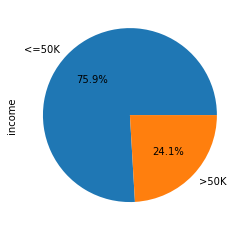

In [3]:
#Imbalanced data
df['income'].value_counts().plot.pie(autopct='%1.1f%%')
#will be dealt with oversampling

In [4]:
# drop education column
for edu in df['education'].unique():
    print("{}, matches Education Number {}".format(edu, df[df['education'] == edu]['education_num'].unique()))
df.drop('education', inplace=True, axis=1)
df_test.drop('education', inplace=True, axis=1)


Bachelors, matches Education Number [13]
HS-grad, matches Education Number [9]
11th, matches Education Number [7]
Masters, matches Education Number [14]
9th, matches Education Number [5]
Some-college, matches Education Number [10]
Assoc-acdm, matches Education Number [12]
Assoc-voc, matches Education Number [11]
7th-8th, matches Education Number [4]
Doctorate, matches Education Number [16]
Prof-school, matches Education Number [15]
5th-6th, matches Education Number [3]
10th, matches Education Number [6]
1st-4th, matches Education Number [2]
Preschool, matches Education Number [1]
12th, matches Education Number [8]


In [5]:
# Remove duplicates
print("number of duplicates:", df.duplicated().sum())
df = df[~df.duplicated()]
df_test= df_test[~df_test.duplicated()]

number of duplicates: 24


In [6]:
# Missing values
for col in df.columns:
    n_missing = (df[col] == '?').sum()
    if n_missing !=0:
        print(f'Column {col} has {n_missing} missing values.')

def oneHot(df, df_cols):
    return pd.concat([df.drop(columns=df_cols), pd.get_dummies(df[df_cols])], axis=1)

def fill_in_missing(df_all):
    columns_with_missing_values = ['workclass', 'occupation', 'native_country']
    for col in columns_with_missing_values:
        print('Filling up column: '+col)

        x_train = df_all[df_all[col] != '?'].copy()
        x_test = df_all[df_all[col] == '?'].copy()
        y_train = x_train[col]

        x_train.drop(columns=[col], inplace=True)
        x_test.drop(columns=[col], inplace=True)
        
        x_train = oneHot(x_train, x_train.select_dtypes('category').columns)
        x_test = oneHot(x_test, x_test.select_dtypes('category').columns)
        
        r_forest = RandomForestClassifier(n_estimators=10)
        r_forest.fit(x_train, y_train)

        pred=r_forest.predict(x_test)
        df_all.loc[df_all[col] == '?', col] = pred
        
        df_all[col] = df_all[col].cat.remove_categories('?')

fill_in_missing(df)
fill_in_missing(df_test)


Column workclass has 1836 missing values.
Column occupation has 1843 missing values.
Column native_country has 582 missing values.
Filling up column: workclass
Filling up column: occupation
Filling up column: native_country
Filling up column: workclass
Filling up column: occupation
Filling up column: native_country


       feature  importance
        fnlwgt   17.513246
           age   15.028399
  capital_gain   11.943820
 education_num   11.796943
  relationship   10.838885
hours_per_week    8.114957
    occupation    6.761287
marital_status    6.345065
     workclass    3.811346
  capital_loss    3.648563
native_country    1.509274
          race    1.396204
           sex    1.292010


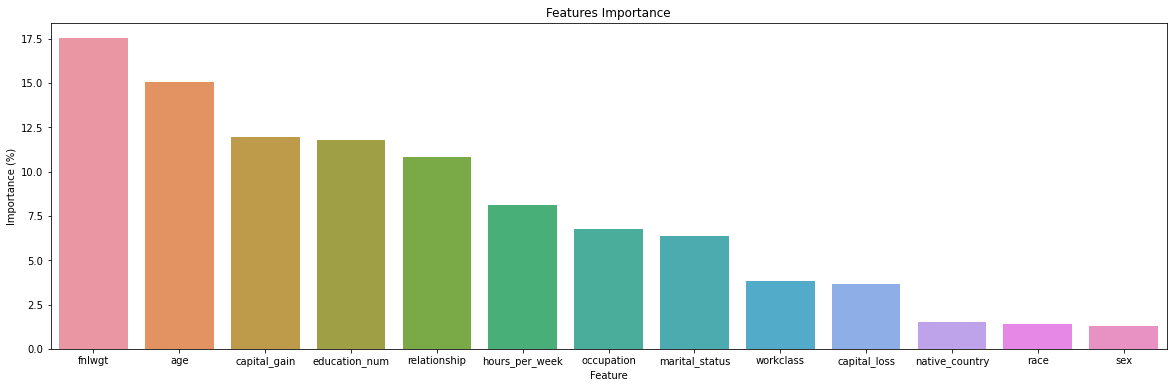

In [7]:
# feature importance
df_1 = df.copy()
df_1[df_1.select_dtypes('category').columns] = df_1.select_dtypes('category').apply(LabelEncoder().fit_transform)
y_1 = df_1['income']     
X_1 = df_1.drop('income', axis=1)

rf = RandomForestClassifier().fit(X_1, y_1)

feature_importance = pd.DataFrame({'feature': X_1.columns.tolist(), 'importance': rf.feature_importances_ * 100}).sort_values(by='importance', ascending=False)
plt.figure(figsize=[20,6])
sb.barplot(data=feature_importance, x='feature', y='importance')
plt.title('Features Importance')
plt.xlabel('Feature')
plt.ylabel('Importance (%)')
print(feature_importance.to_string(index=False))



In [8]:
# biserial correlation
print('correlation between binary variable(income) and numerical variables:')
numerical = ['age', 'capital_gain', 'capital_loss', 'hours_per_week', 'fnlwgt', 'education_num']
for i in numerical:
    print(i,':',stats.pointbiserialr(df_1['income'],df_1[i])[0])
#df_1=df_1.drop('fnlwgt',axis=1) #after dropping, performance dropped


correlation between binary variable(income) and numerical variables:
age : 0.23403709464456293
capital_gain : 0.2233364989203645
capital_loss : 0.1505007653680536
hours_per_week : 0.22965810163854714
fnlwgt : -0.009502349300418267
education_num : 0.3352715122489285


In [9]:
# Scalling
scaler = MinMaxScaler()
df[numerical] = scaler.fit_transform(df[numerical])
df_test[numerical] = scaler.fit_transform(df_test[numerical])

In [10]:
# Encoding
df['income'] = df.income.replace({"<=50K": int(0), ">50K": int(1)})
df_test['income'] = df_test.income.replace({"<=50K": int(0), ">50K": int(1)})
no_income=['age', 'workclass', 'fnlwgt', 'education_num', 'marital_status', 'occupation', 'relationship', 
       'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country']
dummies_df = pd.get_dummies(df[no_income])
dummies_df_test = pd.get_dummies(df_test[no_income])
df = pd.concat([df['income'], dummies_df], axis=1)
df_test = pd.concat([df_test['income'], dummies_df_test], axis=1)


In [11]:
y_train = df['income']
X_train = df.drop('income', axis=1)

y_test = df_test['income']
X_test = df_test.drop('income', axis=1)

#to deal with imbanlanced data: resampling
X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

'''
#another way of resampeling: SMOTE
smote = SMOTE(random_state=2023)
X, y = smote.fit_resample(X, y)
'''


'\n#another way of resampeling: SMOTE\nsmote = SMOTE(random_state=2023)\nX, y = smote.fit_resample(X, y)\n'

In [12]:
column_difference=set(X_train.columns) - set(X_test.columns)
X_test = X_test.assign(column_difference=0)


# Train & Test

In [13]:
#fine-turn parameter, stopping criterion 

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10]}

rf_grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid=param_grid, verbose=3, n_jobs = -1)

rf_grid.fit(X_train, y_train)

print("Best parameters: ", rf_grid.best_params_) 
#Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}

rf_grid_best = rf_grid.best_estimator_
rf_grid_predictions = rf_grid_best.predict(X_test) 
print(classification_report(y_test, rf_grid_predictions))
print("Best score: ", rf_grid.best_score_)
'''
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     12430
           1       0.71      0.65      0.68      3846

    accuracy                           0.85     16276
   macro avg       0.80      0.79      0.79     16276
weighted avg       0.85      0.85      0.85     16276

Best score:  0.9384364638031109
'''

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     12430
           1       0.71      0.65      0.68      3846

    accuracy                           0.85     16276
   macro avg       0.80      0.78      0.79     16276
weighted avg       0.85      0.85      0.85     16276

Best score:  0.9387401280186614


"\nFitting 5 folds for each of 36 candidates, totalling 180 fits\nBest parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}\n              precision    recall  f1-score   support\n\n           0       0.90      0.92      0.91     12430\n           1       0.71      0.65      0.68      3846\n\n    accuracy                           0.85     16276\n   macro avg       0.80      0.79      0.79     16276\nweighted avg       0.85      0.85      0.85     16276\n\nBest score:  0.9384364638031109\n"

In [14]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.01, 0.1, 1],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

lr_grid = GridSearchCV(estimator = LogisticRegression(max_iter=500,tol=0.0001), param_grid=param_grid)

lr_grid.fit(X_train, y_train)

print("Best parameters: ", lr_grid.best_params_)
lr_grid_best = lr_grid.best_estimator_
lr_grid_predictions = lr_grid_best.predict(X_test) 
print(classification_report(y_test, rf_grid_predictions))
print("Best score: ", lr_grid.best_score_)
#f1_score = f1_score(y_test, y_pred)
#print("F1-score on test set:", f1_score)
'''
Best parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     12430
           1       0.71      0.65      0.68      3846

    accuracy                           0.85     16276
   macro avg       0.80      0.79      0.79     16276
weighted avg       0.85      0.85      0.85     16276

Best score:  0.8221314012916615
'''

[CV 4/5] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=100;, score=0.946 total time=  14.8s
[CV 3/5] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=500;, score=0.942 total time= 1.1min
[CV 2/5] END max_depth=None, max_features=auto, min_samples_split=5, n_estimators=100;, score=0.917 total time=  16.7s
[CV 4/5] END max_depth=None, max_features=auto, min_samples_split=5, n_estimators=100;, score=0.936 total time=  14.7s
[CV 2/5] END max_depth=None, max_features=auto, min_samples_split=5, n_estimators=500;, score=0.918 total time= 1.1min
[CV 1/5] END max_depth=None, max_features=auto, min_samples_split=10, n_estimators=100;, score=0.903 total time=  11.6s
[CV 3/5] END max_depth=None, max_features=auto, min_samples_split=10, n_estimators=100;, score=0.919 total time=  11.1s
[CV 5/5] END max_depth=None, max_features=auto, min_samples_split=10, n_estimators=100;, score=0.915 total time=  12.0s
[CV 2/5] END max_depth=None, max_features=aut

[CV 2/5] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=100;, score=0.927 total time=  14.6s
[CV 1/5] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=500;, score=0.930 total time= 1.1min
[CV 5/5] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=500;, score=0.944 total time= 1.2min
[CV 4/5] END max_depth=None, max_features=auto, min_samples_split=5, n_estimators=500;, score=0.936 total time= 1.0min
[CV 3/5] END max_depth=None, max_features=auto, min_samples_split=10, n_estimators=500;, score=0.920 total time=  57.3s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100;, score=0.928 total time=  13.1s
[CV 4/5] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100;, score=0.946 total time=  11.8s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=500;, score=0.927 total time= 1.0min
[CV 1/5] END max_depth=None, max_features=sqrt,

Best parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     12430
           1       0.71      0.65      0.68      3846

    accuracy                           0.85     16276
   macro avg       0.80      0.78      0.79     16276
weighted avg       0.85      0.85      0.85     16276

Best score:  0.8250264024657874


"\nBest parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}\n              precision    recall  f1-score   support\n\n           0       0.90      0.92      0.91     12430\n           1       0.71      0.65      0.68      3846\n\n    accuracy                           0.85     16276\n   macro avg       0.80      0.79      0.79     16276\nweighted avg       0.85      0.85      0.85     16276\n\nBest score:  0.8221314012916615\n"

In [17]:
models = {
    'RandomForest': rf_grid_best,
    'LogisticRegression': lr_grid_best
}
accuracy_dic = dict()
for model_name, model in models.items():
    
    start_fit_time = time.time()

    models[model_name].fit(X_train, y_train)
    fit_time = time.time() - start_fit_time

    start_score_time = time.time()

    y_pred = models[model_name].predict(X_test)
    
    score_time = time.time() - start_score_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(model_name + ":")
    print("Accuracy:", accuracy)
    print('Precision:',precision)
    print('Recall:',recall)
    print("F1-score:", f1)
    print("Time taken: train =", fit_time, "| test =", score_time)
    
    accuracy_dic[model_name]=accuracy

RandomForest:
Accuracy: 0.852727942983534
Precision: 0.7042571186918523
Recall: 0.6495059802392096
F1-score: 0.6757743811713783
Time taken: train = 9.103679895401001 | test = 0.37961912155151367
LogisticRegression:
Accuracy: 0.8212091422954043
Precision: 0.5906625339015885
Recall: 0.7927717108684348
F1-score: 0.6769538188277088
Time taken: train = 2.587538003921509 | test = 0.01058816909790039


RandomForest:
Accuracy: 0.8548169083312853
Precision: 0.7070650656241273
Recall: 0.6583463338533542
F1-score: 0.6818365423454962
Time taken: train = 39.14756107330322 | test = 2.3278751373291016
LogisticRegression:
Accuracy: 0.8151265667240108
Precision: 0.5768030831345201
Recall: 0.8172126885075403
F1-score: 0.6762775685852609
Time taken: train = 6.754455804824829 | test = 0.013499021530151367
RandomForest: ROC AUC=0.907
LogisticRegression: ROC AUC=0.903


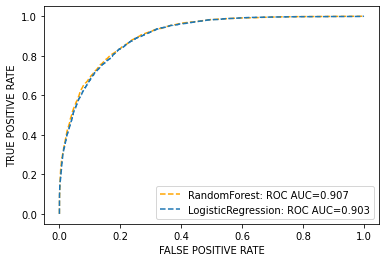

In [18]:
# Models with best parameters
models = {
    'RandomForest': RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_split=2, n_estimators=500),
    #'LogisticRegression': LogisticRegression(C=1, penalty='l1', solver='saga')
    'LogisticRegression': LogisticRegression(C=0.01, penalty='none', solver='newton-cg')
}
accuracy_dic = dict()
    
def eval_model(model_name,model):
    
    start_fit_time = time.time()
    models[model_name].fit(X_train, y_train)
    fit_time = time.time() - start_fit_time

    start_score_time = time.time()
    y_pred = models[model_name].predict(X_test)
    score_time = time.time() - start_score_time

    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(model_name + ":")
    print("Accuracy:", accuracy)
    print('Precision:',precision)
    print('Recall:',recall)
    print("F1-score:", f1)
    print("Time taken: train =", fit_time, "| test =", score_time)
    
    return accuracy

for model_name, model in models.items():
    accuracy = eval_model(model_name,model)
    accuracy_dic[model_name]=accuracy

    
# ROC
ns_probs = models["RandomForest"].predict_proba(X_test)[:, 1]
nb_probs1 = models["LogisticRegression"].predict_proba(X_test)[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
nb_auc = roc_auc_score(y_test, nb_probs1)
# summarize scores
print('RandomForest: ROC AUC=%.3f' % (ns_auc))
print('LogisticRegression: ROC AUC=%.3f' % (nb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs1)
# plot the roc curve for the model

plt.plot(ns_fpr, ns_tpr, linestyle='--', color='orange', label='RandomForest: ROC AUC=%.3f' % (ns_auc))
plt.plot(nb_fpr, nb_tpr, linestyle='--',label='LogisticRegression: ROC AUC=%.3f' % (nb_auc))
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.legend()
plt.show()



# Comparision

In [21]:
# Comparing Performance of 2 Models

print('Evaluate accuracy on testing set')

rf_perf = accuracy_dic['RandomForest']
print(rf_perf)
lr_perf = accuracy_dic['LogisticRegression']
print(lr_perf)

# Calculate difference in accuracy
diff_acc = rf_perf - lr_perf
# Calculate the test statistic for the z-test
lr_var = lr_perf * (1 - lr_perf)/len(y_test)
rf_var = rf_perf * (1 - rf_perf)/len(y_test)

d_std = np.sqrt(lr_var + rf_var)

z_score = 1.96  # for 95% confidence interval
# Calculate confidence interval for the difference in performance
ci_low = diff_acc - z_score * d_std
ci_high = diff_acc + z_score * d_std

print('Logistic Regression performance: {:.4f}'.format(lr_perf))
print('Random Forest performance: {:.4f}'.format(rf_perf))
print('Difference in performance: {:.4f}'.format(diff_acc))
print('Standard error of difference: {:.4f}'.format(d_std))
print('95% confidence interval for difference: [{:.4f}, {:.4f}]'.format(ci_low, ci_high))

Evaluate accuracy on testing set
0.8548169083312853
0.8151265667240108
Logistic Regression performance: 0.8151
Random Forest performance: 0.8548
Difference in performance: 0.0397
Standard error of difference: 0.0041
95% confidence interval for difference: [0.0316, 0.0477]
